# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

### Откроем и изучим файлы

In [2]:
data_full = pd.read_csv('datasets/gold_industry_full.csv')
data_train = pd.read_csv('datasets/gold_industry_train.csv')
data_test = pd.read_csv('datasets/gold_industry_test.csv')

Посмотрим размер файлов

In [3]:
data_full.shape, data_train.shape, data_test.shape

((19439, 87), (14579, 87), (4860, 53))

Посмотрим наименования полей и типы данных

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [6]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

###  Проверим, что эффективность обогащения рассчитана правильно.

Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery и найдём MAE между нашими расчётами и значением признака.

In [7]:
recovery = (data_train['rougher.output.concentrate_au'] * (data_train['rougher.input.feed_au'] - \
            data_train['rougher.output.tail_au'])) / (data_train['rougher.input.feed_au'] * \
            (data_train['rougher.output.concentrate_au'] - data_train['rougher.output.tail_au'])) * 100

In [8]:
print('МАЕ recovery:', mean_absolute_error(data_train['rougher.output.recovery'], recovery))

МАЕ recovery: 9.83758577644259e-15


Значение МАЕ между полученными расчётами и значением признака близко к 0. Это означаем, что эффективность обогащения рассчитана верно.

### Проанализируем признаки, недоступные в тестовой выборке.

Для анализа признаков, недоступных в тестовой выборке, удалим столбцы тестовой выборки из обучающей выборки.

In [9]:
data_train.drop(columns = data_test.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       14578 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  14578 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  14578 non-null  float64
 3   rougher.calculation.au_pb_ratio                     14579 non-null  float64
 4   rougher.output.concentrate_au                       14579 non-null  float64
 5   rougher.output.concentrate_ag                       14579 non-null  float64
 6   rougher.output.concentrate_pb                       14579 non-null  float64
 7   rougher.output.concentrate_sol                      14561 non-null  float64
 8   rougher.output.recovery                             14579 non-null  float64


In [10]:
# добавим недостающие данные в data_test
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery', 'date']], how='left', on='date')

Всего 34 пропущенных признака:
* 13 признаков, относящихся к этапу rougher (флотация) со следующими типами параметров:
    * 4 признака — calculation (расчётные характеристики);
    * 9 признаков — output (параметры продукта).
* 8 признаков, относящихся к этапу secondary_cleaner (вторичная очистка) c типом параметра output (параметры продукта).
* 4 признака, относящихся к этапу secondary_cleaner (вторичная очистка) c типом параметра output (параметры продукта).
* 9 признаков, относящихся к этапу final (финальные характеристики) c типом параметра output (параметры продукта).

Некоторые признаки недоступны, потому что замеряются и/или рассчитываются значительно позже. Также в тестовом наборе нет целевых признаков.

### Предобработка данных

Проверим выборки на явные дубликаты

In [11]:
data_full.duplicated().sum()

0

In [12]:
data_train.duplicated().sum()

0

In [13]:
data_test.duplicated().sum()

0

Явных дубликатов нет

Проверим данные на пропуски

In [14]:
data_full.isna().sum()

date                        0
rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb     100
rougher.input.feed_sol     99
                         ... 
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb      101
final.output.tail_sol       6
Length: 87, dtype: int64

In [15]:
data_train.isna().sum()

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

In [16]:
data_test.isna().sum()

date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


In [17]:
print('Количество пропусков в data_full:', data_full.isna().sum().sum())
print('Количество пропусков в data_train:', data_train.isna().sum().sum())
print('Количество пропусков в data_test:', data_test.isna().sum().sum())

Количество пропусков в data_full: 4481
Количество пропусков в data_train: 3050
Количество пропусков в data_test: 375


Заполним пропуски ближайшими значениями, предварительно отсортировав по дате, т.к. в условии сказано, что соседние по времени параметры часто похожи.

In [18]:
data_full = data_full.sort_values(by='date', ascending = False).fillna(method='ffill')
data_train = data_train.sort_values(by='date', ascending = False).fillna(method='ffill')
data_test = data_test.sort_values(by='date', ascending = False).fillna(method='ffill')

In [19]:
print('Количество пропусков в data_full:', data_full.isna().sum().sum())
print('Количество пропусков в data_train:', data_train.isna().sum().sum())
print('Количество пропусков в data_test:', data_test.isna().sum().sum())

Количество пропусков в data_full: 0
Количество пропусков в data_train: 0
Количество пропусков в data_test: 0


<b> Вывод: </b>
Данные были открыты и изучены. Проверен расчёт эффективности обогащения путём нахождения MAE между расчётом эффективности обогащения на обучающей выборке для признака rougher.output.recovery и значением признака. Также было обнаружено 34 пропущенных признака, недоступных в тестовой выборке. Произведена предобработка данных.

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах

Построим диаграмму концентрации <b> золота (Au) </b> на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

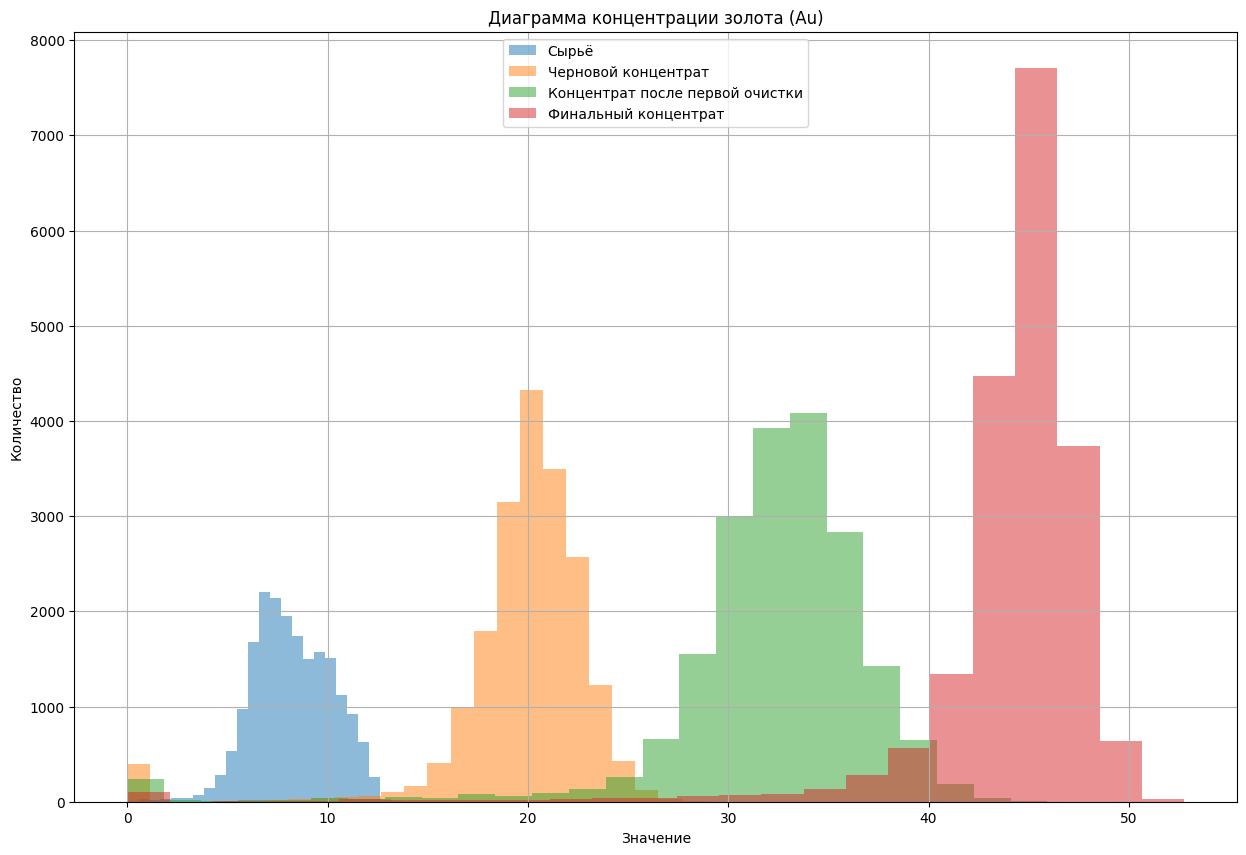

In [20]:
plt.figure(figsize=(15, 10))
data_full['rougher.input.feed_au'].hist(bins=25, label='Сырьё', alpha=0.5)
data_full['rougher.output.concentrate_au'].hist(bins=25, label='Черновой концентрат', alpha=0.5)
data_full['primary_cleaner.output.concentrate_au'].hist(bins=25, label='Концентрат после первой очистки', alpha=0.5)
data_full['final.output.concentrate_au'].hist(bins=25, label='Финальный концентрат', alpha=0.5)
plt.title('Диаграмма концентрации золота (Au)')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.legend(loc='upper center')
plt.show()

In [21]:
# Средняя концентрация золота на стадиях процесса
data_full[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean()

rougher.output.concentrate_au            19.772000
primary_cleaner.output.concentrate_au    32.119400
final.output.concentrate_au              44.076513
dtype: float64

In [22]:
# Средняя концентрация золота в отвальных хвостах
data_full[['rougher.output.tail_au', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au']].mean()

rougher.output.tail_au              1.816391
primary_cleaner.output.tail_au      3.914179
secondary_cleaner.output.tail_au    4.339625
dtype: float64

Построим диаграмму концентрации <b> серебра (Ag) </b> на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

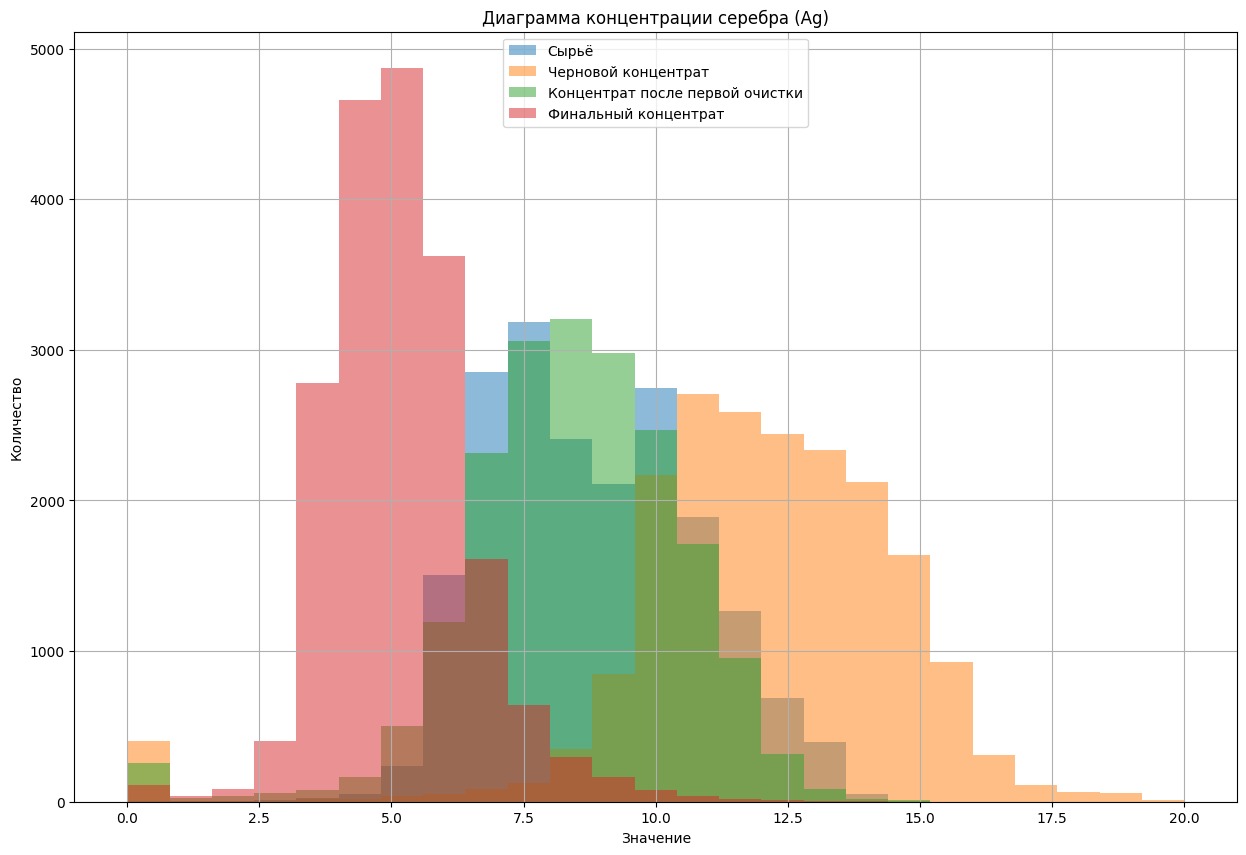

In [23]:
plt.figure(figsize=(15, 10))
data_full['rougher.input.feed_ag'].hist(bins=25, label='Сырьё', alpha=0.5, range = (0, 20))
data_full['rougher.output.concentrate_ag'].hist(bins=25, label='Черновой концентрат', alpha=0.5, range = (0, 20))
data_full['primary_cleaner.output.concentrate_ag'].hist(bins=25, label='Концентрат после первой очистки', alpha=0.5, range = (0, 20))
data_full['final.output.concentrate_ag'].hist(bins=25, label='Финальный концентрат', alpha=0.5, range = (0, 20))
plt.title('Диаграмма концентрации серебра (Ag)')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.legend(loc='upper center')
plt.show()

In [24]:
# Средняя концентрация серебра на стадиях процесса
data_full[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean()

rougher.output.concentrate_ag            11.994759
primary_cleaner.output.concentrate_ag     8.442408
final.output.concentrate_ag               5.168382
dtype: float64

In [25]:
# Средняя концентрация серебра в отвальных хвостах
data_full[['rougher.output.tail_ag', 'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_ag']].mean()

rougher.output.tail_ag               5.589070
primary_cleaner.output.tail_ag      16.145110
secondary_cleaner.output.tail_ag    14.586456
dtype: float64

Построим диаграмму концентрации <b> свинца (Pb) </b> на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

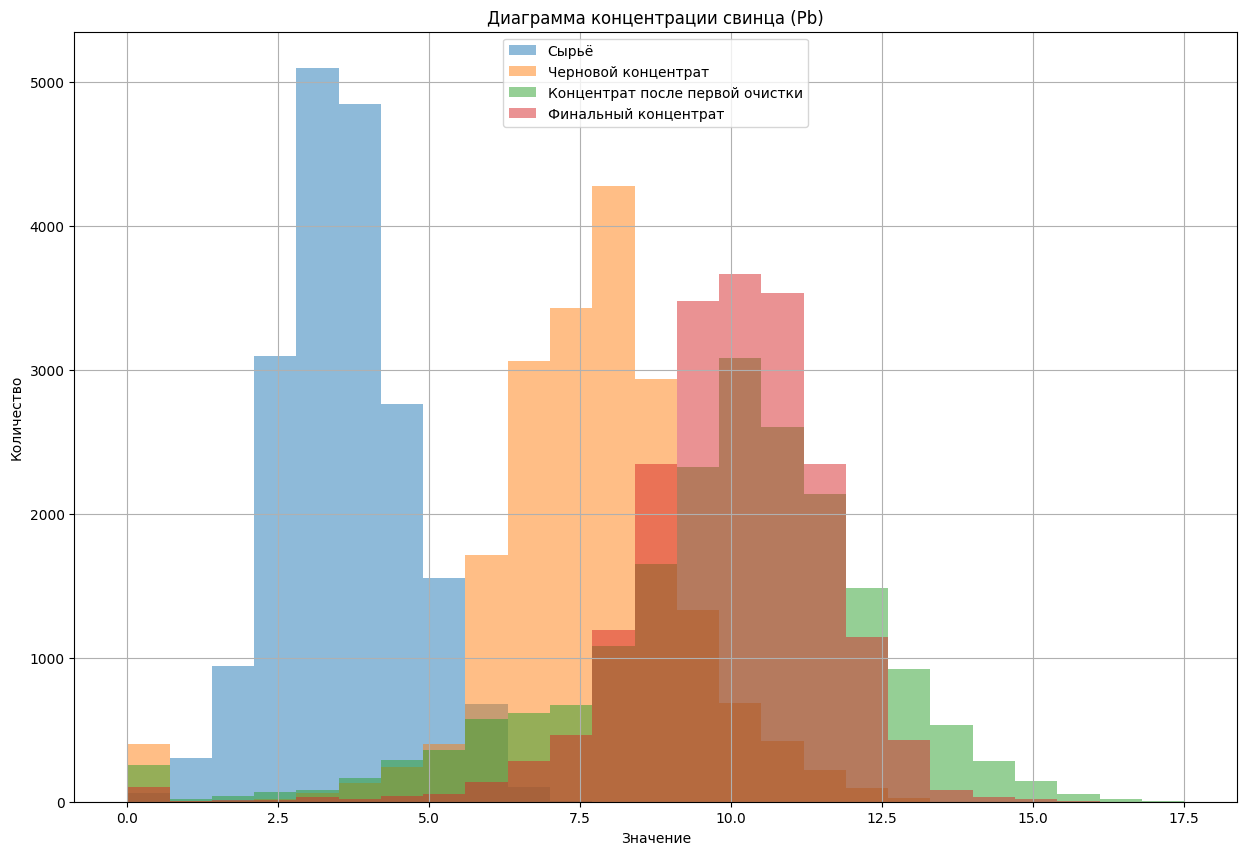

In [26]:
plt.figure(figsize=(15, 10))
data_full['rougher.input.feed_pb'].hist(bins=25, label='Сырьё', alpha=0.5, range = (0, 17.5))
data_full['rougher.output.concentrate_pb'].hist(bins=25, label='Черновой концентрат', alpha=0.5, range = (0, 17.5))
data_full['primary_cleaner.output.concentrate_pb'].hist(bins=25, label='Концентрат после первой очистки', alpha=0.5, range = (0, 17.5))
data_full['final.output.concentrate_pb'].hist(bins=25, label='Финальный концентрат', alpha=0.5, range = (0, 17.5))
plt.title('Диаграмма концентрации свинца (Pb)')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.legend(loc='upper center')
plt.show()

In [27]:
# Средняя концентрация свинца на стадиях процесса
data_full[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean()

rougher.output.concentrate_pb            7.606272
primary_cleaner.output.concentrate_pb    9.811470
final.output.concentrate_pb              9.978817
dtype: float64

In [28]:
# Средняя концентрация свинца в отвальных хвостах
data_full[['rougher.output.tail_pb', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_pb']].mean()

rougher.output.tail_pb              0.645782
primary_cleaner.output.tail_pb      3.433245
secondary_cleaner.output.tail_pb    5.776285
dtype: float64

<b> Вывод: </b>
На каждом этапе обработки сырья концентрация золота значительно увеличивается. Концентрация золота в отвальных хвостах тоже увеличивается, но при этом на порядок ниже. Концентрация серебра постепенно снижается, а то время как в отвельных хвастах увеличивается. Концентрация свинца на стадиях процесса невелика и незначительно увеличивается, как и концентрация в отвальных хвостах.

### Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках

Для сравнения распределения размеров гранул построим график распределения плотности вероятности

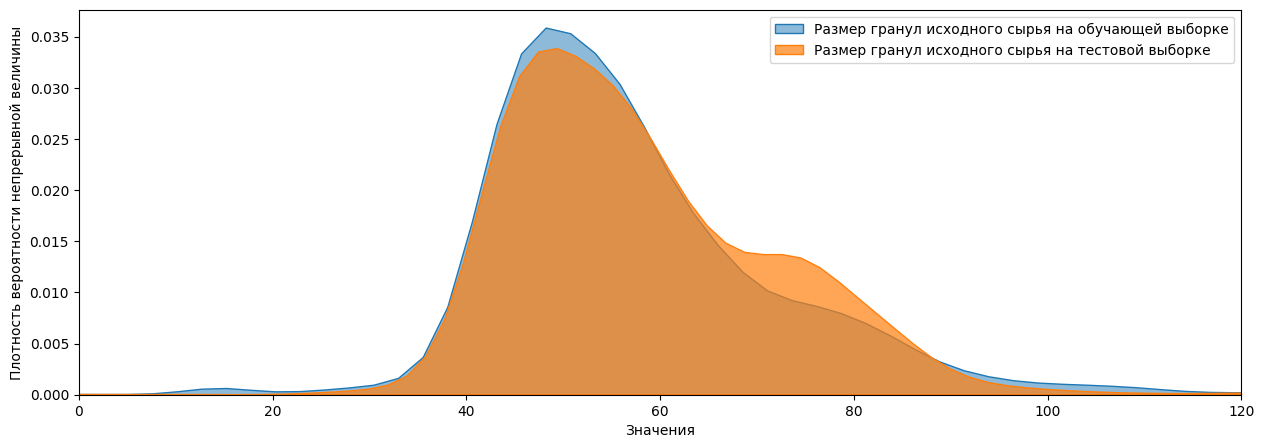

In [29]:
plt.figure(figsize=(15, 5))
sns.kdeplot(data_train['rougher.input.feed_size'], label='Размер гранул исходного сырья на обучающей выборке', alpha=0.5, fill=True)
sns.kdeplot(data_test['rougher.input.feed_size'], label='Размер гранул исходного сырья на тестовой выборке', alpha=0.7, fill=True)
plt.xlim([0, 120])
plt.xlabel('Значения')
plt.ylabel('Плотность вероятности непрерывной величины')
plt.legend(loc='upper right')
plt.show()

In [30]:
print(data_train['rougher.input.feed_size'].describe())

count    14579.000000
mean        58.776732
std         23.144080
min          0.049194
25%         47.171414
50%         54.254915
75%         64.344760
max        484.967466
Name: rougher.input.feed_size, dtype: float64


In [31]:
print(data_test['rougher.input.feed_size'].describe())

count    4860.000000
mean       59.080175
std        19.441844
min         0.046369
25%        47.605339
50%        55.414175
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64


По графику видно, что распределения не сильно отличаются друг от друга и имеют практически одинаковую фигуру, а статистические данные показывают близкие значения, что говорит об однородности размеров гранул исходного сырья на обучающей и тестовой выборках.

### Исследуем суммарную концентрацию металлов на разных стадиях

#### Суммарная концентрацию металлов в сырье

In [32]:
data_full['rougher.input.feed_sum'] = data_full['rougher.input.feed_au'] + \
                            data_full['rougher.input.feed_ag'] + \
                            data_full['rougher.input.feed_pb'] + \
                            data_full['rougher.input.feed_sol']

#### Суммарная концентрацию металлов в черновом концентрате

In [33]:
data_full['rougher_output_concentrate_sum'] = data_full['rougher.output.concentrate_au'] + \
                                    data_full['rougher.output.concentrate_ag'] + \
                                    data_full['rougher.output.concentrate_pb'] + \
                                    data_full['rougher.output.concentrate_sol']

#### Суммарная концентрацию металлов в концентрате после первой очистки

In [34]:
data_full['primary_cleaner_output_concentrate_sum'] = data_full['primary_cleaner.output.concentrate_au'] + \
                                            data_full['primary_cleaner.output.concentrate_ag'] + \
                                            data_full['primary_cleaner.output.concentrate_pb'] + \
                                            data_full['primary_cleaner.output.concentrate_sol']

#### Суммарная концентрацию металлов в финальном концентрате

In [35]:
data_full['final_output_concentrate_sum'] = data_full['final.output.concentrate_au'] + \
                                data_full['final.output.concentrate_ag'] + \
                                data_full['final.output.concentrate_pb'] + \
                                data_full['final.output.concentrate_sol']

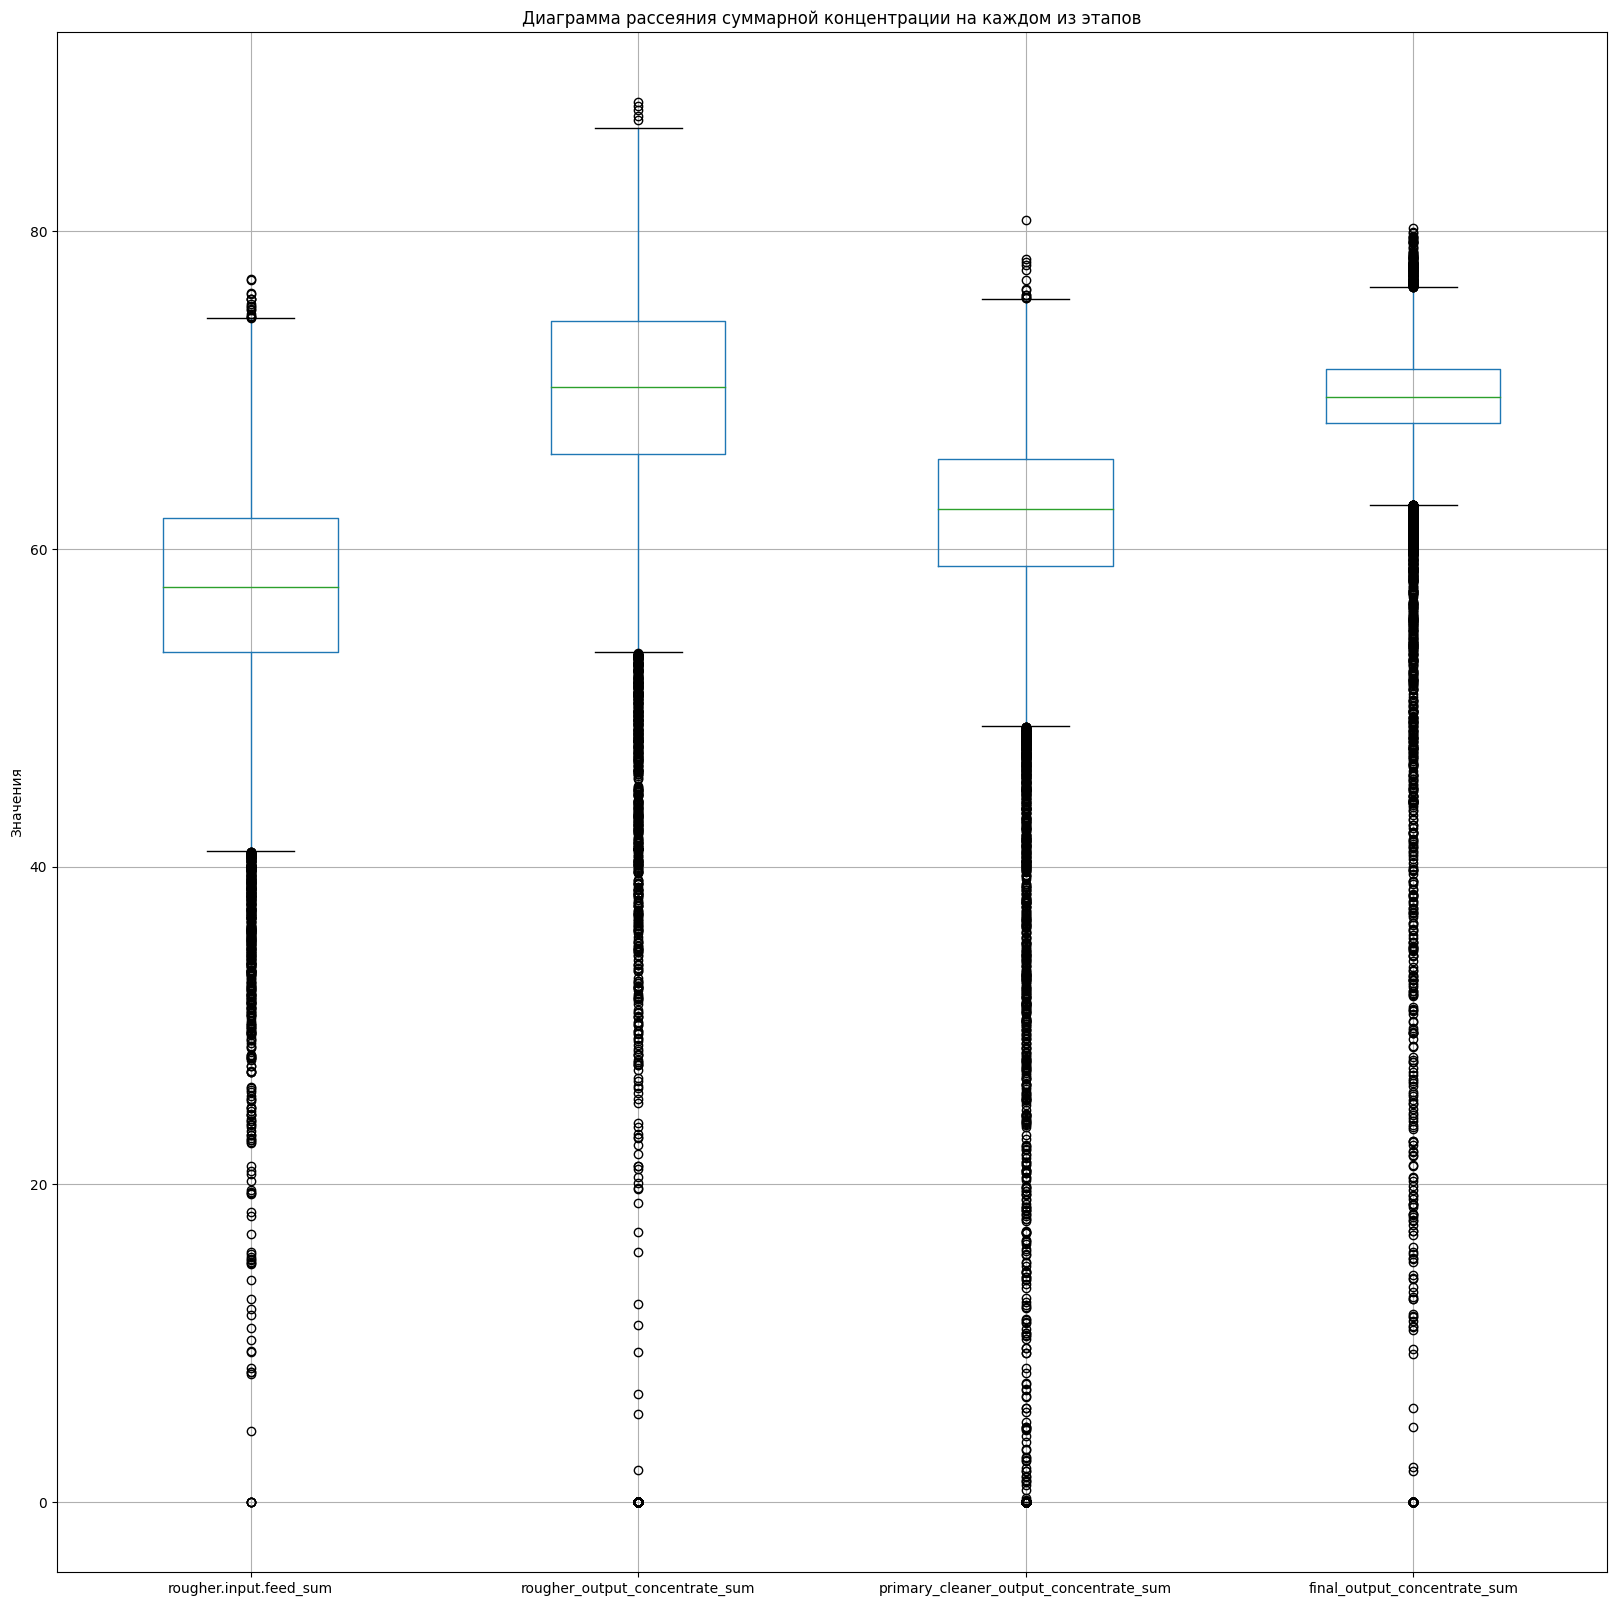

In [36]:
data_full[['rougher.input.feed_sum', 'rougher_output_concentrate_sum', 'primary_cleaner_output_concentrate_sum', 'final_output_concentrate_sum']].boxplot(figsize = (20, 20))
plt.title('Диаграмма рассеяния суммарной концентрации на каждом из этапов')
plt.ylabel('Значения')
plt.show()

Рассчитаем размер усов для rougher.input.feed_sum

In [37]:
final_q1 = np.quantile(data_full['rougher.input.feed_sum'], 0.25)
final_q3 = np.quantile(data_full['rougher.input.feed_sum'], 0.75)
delta_q3_q1 = final_q3 - final_q1
feed_left_moustache = final_q1 - 1.5 * delta_q3_q1
print(' final_q1: ', final_q1, '\n', 'final_q3: ', final_q3, '\n', 'delta_q3_q1: ', delta_q3_q1, '\n', 'feed_left_moustache: ', feed_left_moustache )

 final_q1:  53.544608804817784 
 final_q3:  61.95481192063178 
 delta_q3_q1:  8.410203115814 
 feed_left_moustache:  40.929304131096785


Рассчитаем размер усов для rougher_output_concentrate_sum

In [38]:
final_q1 = np.quantile(data_full['rougher_output_concentrate_sum'], 0.25)
final_q3 = np.quantile(data_full['rougher_output_concentrate_sum'], 0.75)
delta_q3_q1 = final_q3 - final_q1
rougher_left_moustache = final_q1 - 1.5 * delta_q3_q1
print(' final_q1: ', final_q1, '\n', 'final_q3: ', final_q3, '\n', 'delta_q3_q1: ', delta_q3_q1, '\n', 'rougher_left_moustache: ', rougher_left_moustache)

 final_q1:  66.01587724379867 
 final_q3:  74.35934911755449 
 delta_q3_q1:  8.343471873755817 
 rougher_left_moustache:  53.500669433164944


Рассчитаем размер усов для primary_cleaner_output_concentrate_sum

In [39]:
primary_q1 = np.quantile(data_full['primary_cleaner_output_concentrate_sum'], 0.25)
primary_q3 = np.quantile(data_full['primary_cleaner_output_concentrate_sum'], 0.75)
delta_q3_q1 = primary_q3 - primary_q1
primary_left_moustache = primary_q1 - 1.5 * delta_q3_q1
print(' primary_q1: ', final_q1, '\n', 'primary_q3: ', final_q3, '\n', 'delta_q3_q1: ', delta_q3_q1, '\n', 'primary_cleaner_left_moustache: ', primary_left_moustache )

 primary_q1:  66.01587724379867 
 primary_q3:  74.35934911755449 
 delta_q3_q1:  6.735659024865512 
 primary_cleaner_left_moustache:  48.827390557494574


Рассчитаем размер усов для final_output_concentrate_sum

In [40]:
final_q1 = np.quantile(data_full['final_output_concentrate_sum'], 0.25)
final_q3 = np.quantile(data_full['final_output_concentrate_sum'], 0.75)
delta_q3_q1 = final_q3 - final_q1
final_left_moustache = final_q1 - 1.5 * delta_q3_q1
print(' final_q1: ', final_q1, '\n', 'final_q3: ', final_q3, '\n', 'delta_q3_q1: ', delta_q3_q1, '\n', 'final_left_moustache: ', final_left_moustache )

 final_q1:  67.93739008969514 
 final_q3:  71.36939320472288 
 delta_q3_q1:  3.43200311502774 
 final_left_moustache:  62.78938541715353


Бросается в глаза большой хвост выбросов для значений от левого уса и до нуля. Для всех суммарных концентраций значения левого уса рассчитаны. Удалим выбросы, попадающие в этот промежуток и подготовим новую выборку без выбросов.

In [41]:
data_full_emission_free = \
data_full[(data_full['rougher.input.feed_sum'] >= feed_left_moustache)\
         &(data_full['rougher_output_concentrate_sum'] >= rougher_left_moustache)\
         &(data_full['primary_cleaner_output_concentrate_sum'] >= primary_left_moustache)\
         &(data_full['final_output_concentrate_sum'] >= final_left_moustache)]
data_full_emission_free.shape

(16683, 91)

In [42]:
data_train['rougher.input.feed_sum'] = data_train['rougher.input.feed_au'] + \
                            data_train['rougher.input.feed_ag'] + \
                            data_train['rougher.input.feed_pb'] + \
                            data_train['rougher.input.feed_sol']

data_train['rougher_output_concentrate_sum'] = data_train['rougher.output.concentrate_au'] + \
                                    data_train['rougher.output.concentrate_ag'] + \
                                    data_train['rougher.output.concentrate_pb'] + \
                                    data_train['rougher.output.concentrate_sol']

data_train['primary_cleaner_output_concentrate_sum'] = data_train['primary_cleaner.output.concentrate_au'] + \
                                            data_train['primary_cleaner.output.concentrate_ag'] + \
                                            data_train['primary_cleaner.output.concentrate_pb'] + \
                                            data_train['primary_cleaner.output.concentrate_sol']

data_train['final_output_concentrate_sum'] = data_train['final.output.concentrate_au'] + \
                                data_train['final.output.concentrate_ag'] + \
                                data_train['final.output.concentrate_pb'] + \
                                data_train['final.output.concentrate_sol']

In [43]:
data_train_emission_free = \
data_train[(data_train['rougher.input.feed_sum'] >= feed_left_moustache)\
         &(data_train['rougher_output_concentrate_sum'] >= rougher_left_moustache)\
         &(data_train['primary_cleaner_output_concentrate_sum'] >= primary_left_moustache)\
         &(data_train['final_output_concentrate_sum'] >= final_left_moustache)]
data_train_emission_free.shape

(12348, 91)

In [44]:
features_columns = list(data_test.columns)[1:-2]
target_columns = list(reversed(list(data_test.columns)[-2:]))
features_train = data_train_emission_free[features_columns]
target_train = data_train_emission_free[target_columns]
features_test = data_test[features_columns]
target_test = data_test[target_columns]

<b> Вывод: </b>
На каждом этапе обработки сырья концентрация золота значительно увеличивается. Концентрация золота в отвальных хвостах тоже увеличивается, но при этом на порядок ниже. Концентрация серебра постепенно снижается, а то время как в отвельных хвастах увеличивается. Концентрация свинца на стадиях процесса невелика и незначительно увеличивается, как и концентрация в отвальных хвостах.
Сравнивая распределения размеров гранул исходного сырья на обучающей и тестовой выборке, можно сказать, что данные о размере гранул однородны. Также исследованы суммарные концентрации металлов на разных стадиях, удалены выбросы и подготовлены выборки для модели.

## Модель

Функция для вычисления sMAPE

In [45]:
def smape_func(target, pred):
    smape = abs(target-pred)/((abs(target)+abs(pred))/2)*100
    smape = smape.fillna(value=0)
    smape = np.mean(smape)
    return smape

Функция для вычисления итоговой sMAPE

In [46]:
def summary_smape_func(target_rouger, pred_rougher, target_final, pred_final):
    smape_rouger = smape_func(target_rouger, pred_rougher)
    smape_final = smape_func(target_final, pred_final)
    summary_smape = 0.25 * smape_rouger + 0.75 * smape_final
    return summary_smape

In [47]:
def summary_smape(smape_rouger, smape_final):
    summary_smape = 0.25 * smape_rouger + 0.75 * smape_final
    return summary_smape

Обучим разные модели и оценим их качество кросс-валидацией

<b> Линейная регрессия </b>

In [48]:
smape_scorer = make_scorer(smape_func, greater_is_better=False)

In [49]:
# инициируем модель линейной регрессии
model_line_reg_rougher = LinearRegression()

In [50]:
# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_line_reg_rougher = cross_val_score(model_line_reg_rougher,  
                                          features_train, 
                                          target_train['rougher.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_rougher = np.mean(abs(scores_line_reg_rougher))
print('Средняя оценка качества sMape_rougher', round(smape_rougher, 4))

Средняя оценка качества sMape_rougher 7.1206


In [51]:
# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим score_final
scores_line_reg_rougher = cross_val_score(model_line_reg_rougher,  
                                          features_train, 
                                          target_train['final.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_final = np.mean(abs(scores_line_reg_rougher))
print('Средняя оценка качества sMape_final', round(smape_final, 4))

Средняя оценка качества sMape_final 8.9855


In [52]:
# вычислим итоговую оценку sMape
smape_total = summary_smape(smape_rougher, smape_final)
print('Средняя итоговая оценка качества модели sMape ', round(smape_total, 4))

Средняя итоговая оценка качества модели sMape  8.5193


<b> Дерево решений </b>

Проведем оценку модели дерева решений с заданным параметром глубины 10

In [53]:
# Проведем оценку для этапа rougher

# Инициируем модель дерева решений
model_dtree_rougher = DecisionTreeRegressor(random_state=12345, max_depth = 10)

# обучим модель
model_dtree_rougher.fit(features_train, target_train['rougher.output.recovery'])

# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_dtree_rougher = cross_val_score(model_dtree_rougher,  
                                          features_train, 
                                          target_train['rougher.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_rougher = np.mean(abs(scores_dtree_rougher))
print('Средняя оценка качества smape_rougher', round(smape_rougher, 4))

Средняя оценка качества smape_rougher 6.8323


In [54]:
# Проведем оценку для этапа final

# Инициируем модель дерева решений
model_dtree_final = DecisionTreeRegressor(random_state=12345, max_depth = 10)

# обучим модель
model_dtree_final.fit(features_train, target_train['final.output.recovery'])

# оценим модель с помощью кроссвалидации features_train, target_train. Вычислим sMape_rougher
scores_dtree_final = cross_val_score(model_dtree_final,  
                                          features_train, 
                                          target_train['final.output.recovery'], 
                                          scoring = smape_scorer,
                                          cv = 5)
smape_final = np.mean(abs(scores_dtree_final))
print('Средняя оценка качества smape_final', round(smape_final, 4))

Средняя оценка качества smape_final 13.1035


In [55]:
# вычислим итоговую оценку sMape
smape_total = summary_smape(smape_rougher, smape_final)
print('Средняя итоговая оценка качества модели sMape', round(smape_total, 4))

Средняя итоговая оценка качества модели sMape 11.5357


Проведем оценку модели дерева решений но уже с подбором параметра глубины

In [56]:
# Проведем оценку модели дерева решений но уже с подбором параметра глубины для этапа rougher
# Инициируем модель дерева решений
model_dtree_rougher = DecisionTreeRegressor(random_state=12345)
# подберем оптимальные параметры глубины дерева
parameters = {'max_depth': [x for x in range(1, 30, 2)]}

grid_dt_rougher = GridSearchCV(model_dtree_rougher,
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer)
grid_dt_rougher.fit(features_train, target_train['rougher.output.recovery'])

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                       23, 25, 27, 29]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [57]:
# Смотрим лучшие параметры по глубине. Значение smape берем по модулю
print(grid_dt_rougher.best_params_)
print('Значение smape_rougher берем по модулю', abs(round(grid_dt_rougher.best_score_, 3)))

{'max_depth': 3}
Значение smape_rougher берем по модулю 6.099


In [58]:
# Проведем оценку модели дерева решений, но уже с подбором параметра глубины для этапа final
# Инициируем модель дерева решений
model_dtree_final = DecisionTreeRegressor(random_state=12345)
# подберем оптимальные параметры глубины дерева
parameters = {'max_depth': [x for x in range(1, 30, 2)]}

grid_dt_final = GridSearchCV(model_dtree_final,
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer)
grid_dt_final.fit(features_train, target_train['final.output.recovery'])

# Смотрим лучшие параметры по глубине. Значение smape берем по модулю
print(grid_dt_final.best_params_)
print('Значение smape_final берем по модулю', abs(round(grid_dt_final.best_score_, 3)))

{'max_depth': 1}
Значение smape_final берем по модулю 8.19


In [59]:
# вычислим итоговую оценку dtree_smape_total
dtree_smape_total = summary_smape(abs(round(grid_dt_rougher.best_score_, 3)), abs(round(grid_dt_final.best_score_, 3)))
print('Средняя итоговая оценка качества модели dtree_smape_total', round(smape_total, 4))

Средняя итоговая оценка качества модели dtree_smape_total 11.5357


<b> Случайный лес </b>

In [60]:
# Проведем оценку модели случайного леса с заданными параметрами для этапа rougher
#  инициируем модель случайного леса
model_rf_rougher = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)

# оценим модель с помощью кроссвалидации features_train, target_train
scores_rf_rougher = cross_val_score(model_rf_rougher,
                                    features_train, 
                                    target_train['rougher.output.recovery'],
                                    scoring=smape_scorer,
                                    cv = 5)
smape_rf_rougher = np.mean(abs(scores_rf_rougher))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_rf_rougher, 4))

Средняя оценка качества модели final_score_rf_rougher 5.9321


In [61]:
# Проведем оценку модели случайного леса с заданными параметрами для этапа final
#  инициируем модель случайного леса
model_rf_final = RandomForestRegressor(random_state=12345, max_depth = 10, n_estimators=20)

# оценим модель с помощью кроссвалидации features_train, target_train
scores_rf_final = cross_val_score(model_rf_final,
                                    features_train, 
                                    target_train['final.output.recovery'],
                                    scoring=smape_scorer,
                                    cv = 5)
smape_rf_final = np.mean(abs(scores_rf_final))
print('Средняя оценка качества модели final_score_rf_rougher', round(smape_rf_final, 4))

Средняя оценка качества модели final_score_rf_rougher 9.1483


In [62]:
# вычислим итоговую оценку smape_rf_total 
smape_rf_total = summary_smape(smape_rf_rougher, smape_rf_final)
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_rf_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 8.3443


In [63]:
# Проведем оценку модели случайного леса с подбором параметров для этапа rougher

#  инициируем модель случайного леса
model_rf_rougher = RandomForestRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
parameters = { 'max_depth': [x for x in range(2, 12, 3)],
               'n_estimators': [x for x in range(5, 52, 5)]
               }

grid_rf_rougher = GridSearchCV(model_rf_rougher, 
                               parameters, 
                               cv=5,
                               scoring=smape_scorer,
                               n_jobs=-1
                              )
grid_rf_rougher.fit(features_train, target_train['rougher.output.recovery'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 11],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                          50]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [64]:
print('Лучшие параметры: ', grid_rf_rougher.best_params_)
print('smape_rougher', abs(round(grid_rf_rougher.best_score_, 3)))

Лучшие параметры:  {'max_depth': 5, 'n_estimators': 20}
smape_rougher 5.859


In [65]:
# Проведем оценку модели случайного леса с подбором параметров для этапа final

#  инициируем модель случайного леса
model_rf_final = RandomForestRegressor(random_state=12345)

# подберем оптимальные параметры глубины дерева
parameters = { 'max_depth': [x for x in range(2, 12, 3)],
               'n_estimators': [x for x in range(5, 52, 5)]
             }

grid_rf_final = GridSearchCV(model_rf_final, 
                               parameters, 
                               cv=5, 
                               scoring=smape_scorer,
                               n_jobs=-1
                              )
grid_rf_final.fit(features_train, target_train['final.output.recovery'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 11],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45,
                                          50]},
             scoring=make_scorer(smape_func, greater_is_better=False))

In [66]:
print('Лучшие параметры: ', grid_rf_final.best_params_)
print('smape_rougher', round(abs(grid_rf_final.best_score_), 3))

Лучшие параметры:  {'max_depth': 2, 'n_estimators': 50}
smape_rougher 8.136


In [67]:
# вычислим итоговую оценку smape_rf_total с учётом подбора параметров 

smape_rf_total = summary_smape(abs(round(grid_rf_rougher.best_score_, 3)), abs(round(grid_rf_final.best_score_, 3)))
print('Средняя итоговая оценка качества модели smape_rf_total', round(smape_rf_total, 4))

Средняя итоговая оценка качества модели smape_rf_total 7.5667


Для дальнешего прогнозирования выбираем модель случайного леса с параметрами

1. для этапа rougher глубина 5, количество деревьев 20.
2. для этапа final глубина 2, количество деревьев 50.

Эти параметры позволяют получить на кросс-валидации показатель smape равный 7.5667


<b> Расчёт по выбранной модели </b>

Теперь мы можем выполнить расчёт параметра smape на тестовых данных

In [68]:
def rf_model(features_train, target_train, features_test, depth, estimators):
    # метод прогнозирования целевого признаки на случайном лесе

    # инициируем модель с лучшими параметрами
    model_rf = RandomForestRegressor(random_state=12345, max_depth = depth, n_estimators=estimators)
    # обучим модель
    model_rf.fit(features_train, target_train)
    # подготовим прогноз целевого признака
    pred_test_rf = model_rf.predict(features_test)

    return pred_test_rf

In [69]:
# спрогнозируем эффективность для этапа rougher
pred_test_rougher = rf_model(features_train, target_train['rougher.output.recovery'], features_test, 5, 150)

In [70]:
# спрогнозируем эффективность для этапа final
pred_test_final = rf_model(features_train, target_train['final.output.recovery'], features_test, 5, 200)

In [71]:
# рассчитаем smape на тестовых данных
smape_test = summary_smape_func(target_test['rougher.output.recovery'],
                                pred_test_rougher,
                                target_test['final.output.recovery'],
                                pred_test_final
                                )

In [72]:
print('Итоговая оценка smape на тестовых данных равна', round(smape_test, 2))

Итоговая оценка smape на тестовых данных равна 6.37


<b> Проверка модели на адекватность </b>

In [73]:
def const_model(features_train, target_train, features_test):
    # метод прогнозирования целевого признаки на константной модели

    # инициируем модель с лучшими параметрами
    dummy_regr = DummyRegressor(strategy="mean")
    # обучим модель
    dummy_regr.fit(features_train, target_train)
    # подготовим прогноз целевого признака
    pred_test = dummy_regr.predict(features_test)
    return pred_test

In [74]:
# построим прогноз константной модели для этапа rougher
pred_test_rougher_const = const_model(features_train, target_train['rougher.output.recovery'], features_test)

In [75]:
# построим прогноз константной модели для этапа final
pred_test_final_const = const_model(features_train, target_train['final.output.recovery'], features_test)

In [76]:
# рассчитаем smape на тестовых данных
smape_test_const = summary_smape_func(target_test['rougher.output.recovery'],
                                      pred_test_rougher_const,
                                      target_test['final.output.recovery'],
                                      pred_test_final_const
                                      )

In [77]:
print('Итоговая оценка smape константной модели на тестовых данных равна', round(smape_test_const, 3))

Итоговая оценка smape константной модели на тестовых данных равна 8.347


<b> Вывод </b>

В рамках предобработки данных проекта, изучены загруженные файлы.
Проверен расчёт эффективности обогащения. Вычислено значение MAE между данными и расчётными значениями эффективности. Полученные значения МАЕ близки к 0. Это означаем, что эффективность обогащения рассчитана правильно.
Проанализированы поля недоступные в тестовой выборке, где отсутствуют целевые признаки для моделей 'rougher.output.recovery', 'final.output.recovery', а также значения output по всем операциям по всем элементам. Это концентрации элементов после основных операций. Это фактические даные, которые мы можем получить только по факту реальных измерений. А задача ML-модели получение прогноза. Поэтому в реальности у нас и не должно быть этих данных в файле test.
Проведена проверка на дубликаты. Обработаны пропуски.
Анализ концентрации металлов показал, что концентрация золота значительно увеличивается на каждом этапе обработки сырья. Концентрация золота в отвальных хвостах тоже увеличивается, но при этом на порядок ниже чем в сырье. На всех графиках концентрации сырья видны значения равные нулю. Судя по распределению, это выбросы.
Построены графики распределения плотности вероятности значений размеров гранул на входе в этапы флотации и финальной очистки выборок train и test Сами распределения похожи, что говорит об однородности данных размеров сырья в выборках train и test.
Исследована суммарная концентрация всех веществ на разных стадиях.
Бросается в глаза большой хвост выбросов для значений от левого уса до нуля. Для всех суммарных концентраций значения левого уса рассчитаны. Удалены выбросы попадающие в этот промежуток.
Подготовлены датафреймы для прогнозирования features, target
Описана функция для вычисления итоговой sMAPE.
На данных train обучены модели линейной регрессии, дерева решений, а также случайного леса. Проведена оценка каждой модели. В результате для дальнейшего прогнозирования выбрана модель случайного леса с параметрами:

Для дальнейшего прогнозирования выбираем модель случайного леса с параметрами:

1. для этапа rougher глубина 5, количество деревьев 20.
2. для этапа final глубина 2, количество деревьев 50.

Эти параметры позволяют получить на кросс-валидации показатель smape равный 7.5667

Итоговый расчёт на тестовых данных выбранной модели случайного леса позволил получить прогноз целевых признаков концентрации золота для этапа флотации и финальной очистки с показателем smape равным 6.37.

Проведена проверка модели на адекватность. Итоговая оценка smape константной модели на тестовых данных равна 8.347